In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as pl
from numpy import fft
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import pandas as pd
%config InlineBackend.figure_format = "retina"
from matplotlib.font_manager import FontProperties


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
## udf 

def plot_prediction_real(prediction,y,n_pred):
    ## more detains about 
    plt.figure(figsize=(15,5))
    plt.plot(list(prediction[-n_pred:]), c= 'g')
    plt.plot(list(y), c= 'r')
    ## formatting 

    plt.ylabel('Stock Price')
    plt.legend(['Real','Predicted'])

    ## rmse 
    rmse = round(np.sqrt(np.mean((prediction[-n_pred:] - y)**2)),2)
    plt.title('RMSE = ' + str(rmse), fontsize=15)
    
def plotting_ts_entire_period(data,prediction,n_pred):
    ## plot result 
    plt.figure(figsize=(15,5))

    pl.plot(np.arange(0, prediction.size), prediction, c = 'g', label = 'Fourier Prediction')
    pl.plot(np.arange(0, data.size), data, c = 'b',label = 'Observation', linewidth = 3)

    ##give a line to show which part is prediction data 
    plt.axvline(x=data.shape[0]-n_pred, ymax = 1, linewidth=3, color='r')
    plt.grid(True)
    pl.legend()
    pl.show()
    
    
def fourier_diff(x,n_predict):
    n = x.size
    n_harm = 7                 # number of harmonics in model
    t = np.arange(0, n)

    x_diff = x.diff()
    x_diff = x_diff.replace(np.nan,0)
    
    ## dickfuller test to see if the time series data is stationary 
    dftest_y = sm.tsa.adfuller(x_diff,autolag='BIC')
    dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    stationary = dfoutput_y[1]<0.05
    print('dependent stationary for trainning: %s'%(stationary))  
    
    ## start to train  
    x_freqdom = fft.fft(x_diff)

    f = fft.fftfreq(n) 

    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    
    #inverse difference to price     
    startValue = x[0]
    pred_fourier = startValue + np.cumsum(restored_sig)
    return  pred_fourier,restored_sig

def fourier_regular(x,n_predict):
    n = x.size
    n_harm = 7                 # number of harmonics in model
    t = np.arange(0, n)

    x_diff = x.diff()
    x_diff = x_diff.replace(np.nan,0)
    
    ## dickfuller test to see if the time series data is stationary 
    dftest_y = sm.tsa.adfuller(x_diff,autolag='BIC')
    dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    stationary = dfoutput_y[1]<0.05
    print('dependent stationary for trainning: %s'%(stationary))  
    
    ## start to train  
    x_freqdom = fft.fft(x_diff)

    f = fft.fftfreq(n) 

    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    
    #inverse difference to price     
    startValue = x[0]
    pred_fourier = startValue + np.cumsum(restored_sig)
    return  pred_fourier,restored_sig



def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 7                 # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    
    ## dickfuller test to see if the time series data is stationary 
    dftest_y = sm.tsa.adfuller(x_notrend,autolag='BIC')
    dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    stationary = dfoutput_y[1]<0.05
    print('dependent stationary for trainning: %s'%(stationary)) 
    
    ## start to train the model 
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    
    return restored_sig + p[0] * t,restored_sig
  

def get_stock_price(ticker):
    import quandl
    quandl.ApiConfig.api_key = 'ik6y9JyGpmnDBkJjiF2Y'

    # get the table for daily stock prices and,
    # filter the table for selected tickers, columns within a time range
    # set paginate to True because Quandl limits tables API to 10,000 rows per call
    data = quandl.get_table('WIKI/PRICES', ticker = [str(ticker)], 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                            date = { 'gte': '2014-12-31', 'lte': '2018-3-21' }, 
                            paginate=True)
    data = data.sort_values(by='date', ascending=True)
    data= data.reset_index(drop = True)
    data = data['adj_close']
    return data

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax


## Data Import and  Preparation 

In [217]:
# I have used this dataset for AMRIMA model and RNN
# And for the project1, RNN beats ARIMA model. 
# ARIMA is the derivative of ARIMA that added 3 parameters, which means still in time domain. 
# I decide to move to frequency domain -- Utilzing fourier transformation to predict stock trend
# let see if fourier can beat RNN! 

In [218]:
data = get_stock_price('GOOGL')

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(<matplotlib.axes._subplots.AxesSubplot at 0x1a1eb6cc18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1c5058d0>)

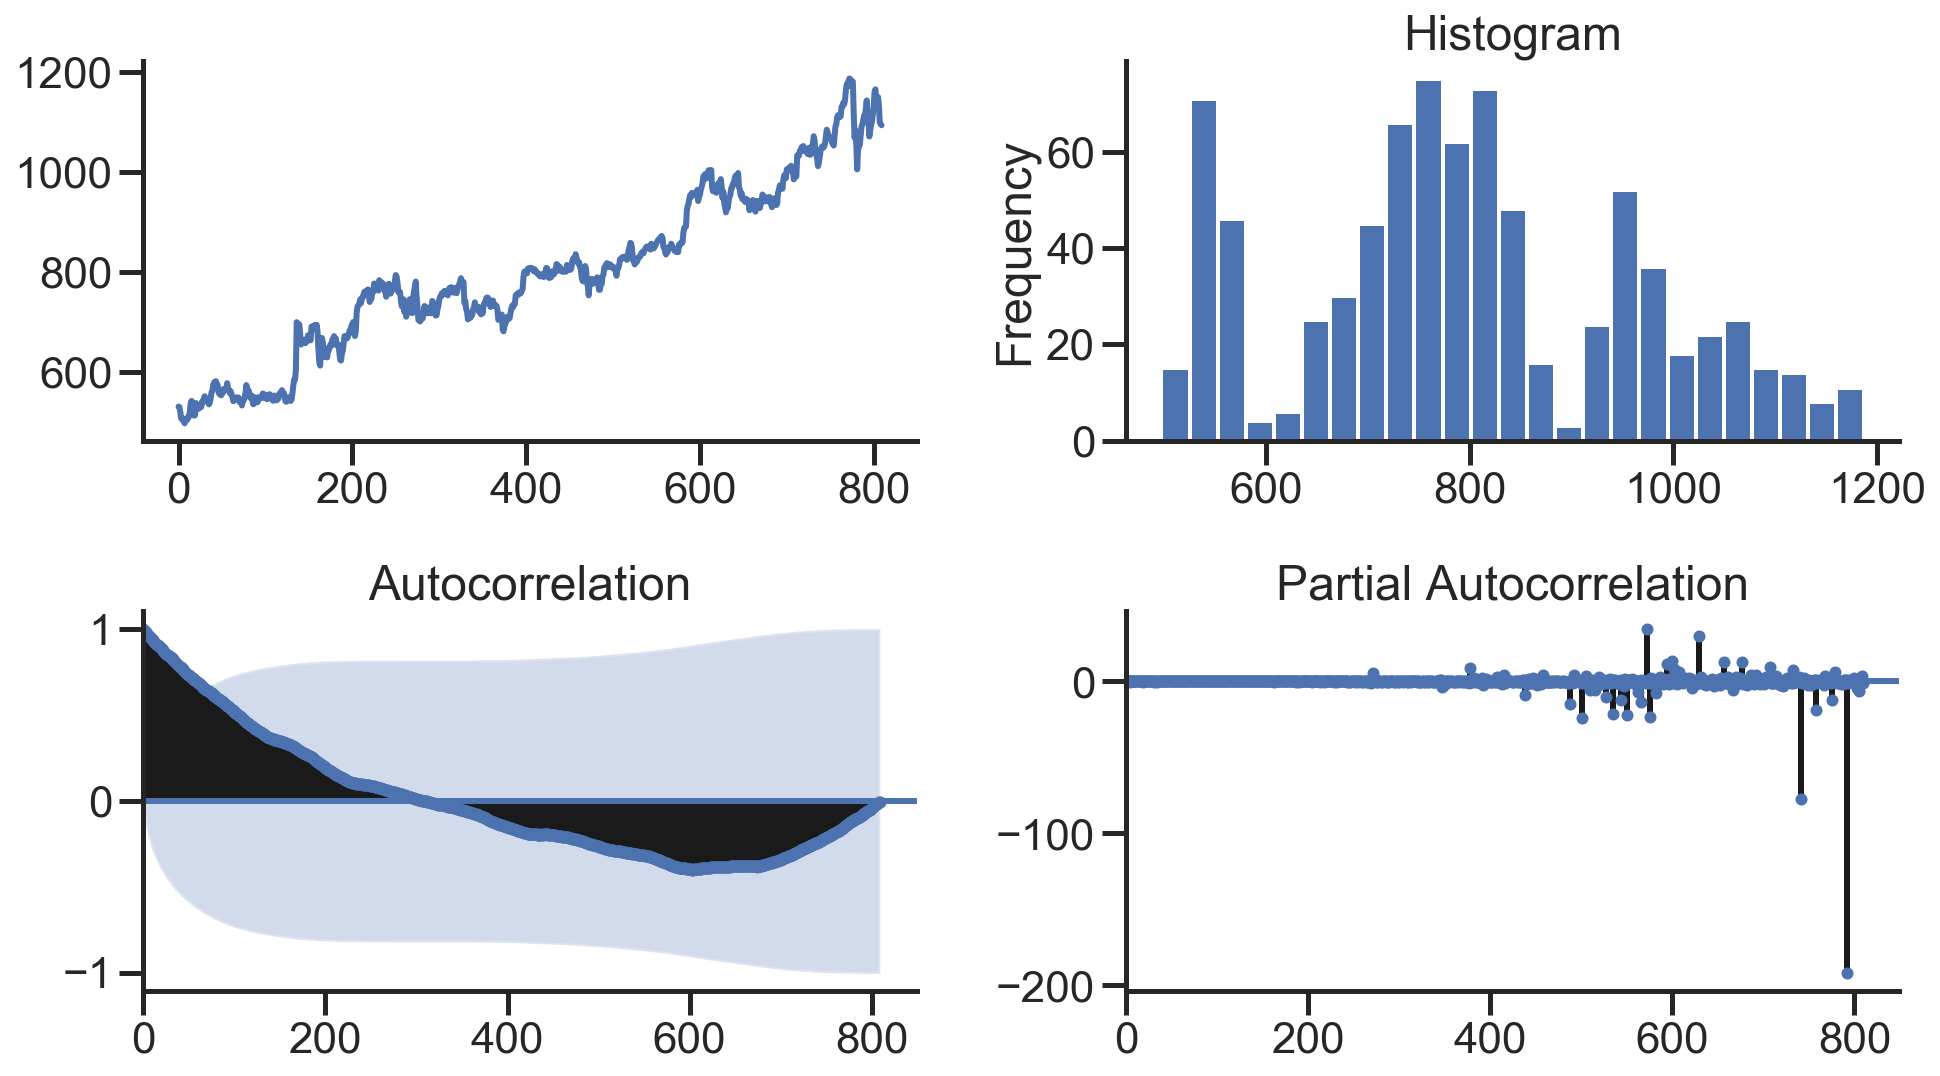

In [219]:
## we have already explore the data set last time
## however, let's do this again.
tsplot(data, lags=None, title='', figsize=(14, 8))
## the graph is not stationary. 

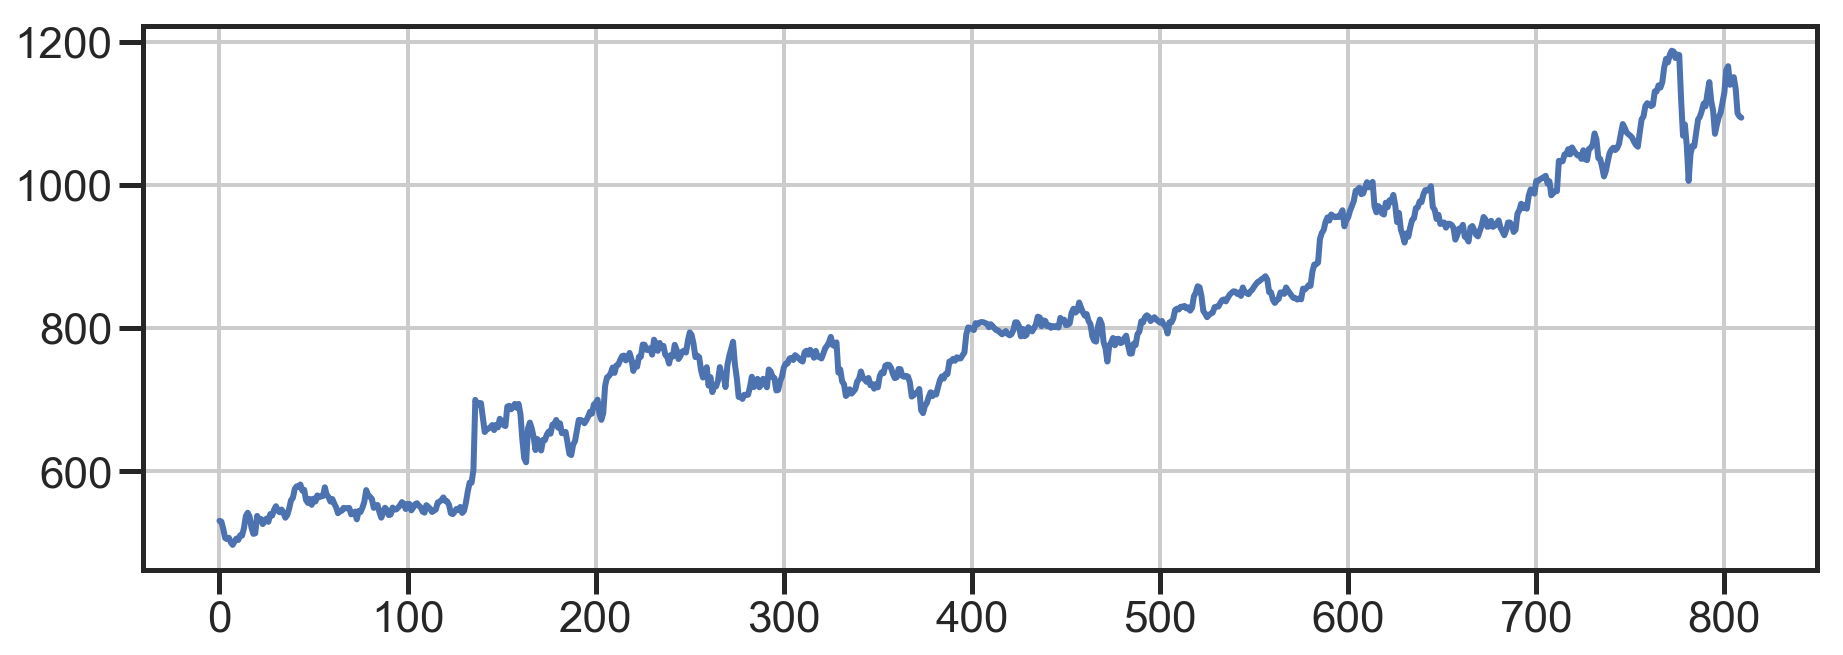

In [220]:
## signal plotting 
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(data)

In [221]:
## predict next 15 days trend.
n_pred = 30

## Detrend and Utilizing Fourier 

In [222]:
data = get_stock_price('GOOGL')

In [223]:
## start to train model 
x = data[:-n_pred]
y = data[-n_pred:]
extrapolation ,pred = fourierExtrapolation(x, n_pred)

dependent stationary for trainning: True


In [224]:
## dickfuller test to see if the residual is white noise 
residual = pred[-n_pred:]-y
dftest_y = sm.tsa.adfuller(residual,autolag='BIC')
dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
WN = dfoutput_y[1]>0.05
print('White noise for residual : %s'%(WN))  
## The model is fine. Residual is white noise 

White noise for residual : True


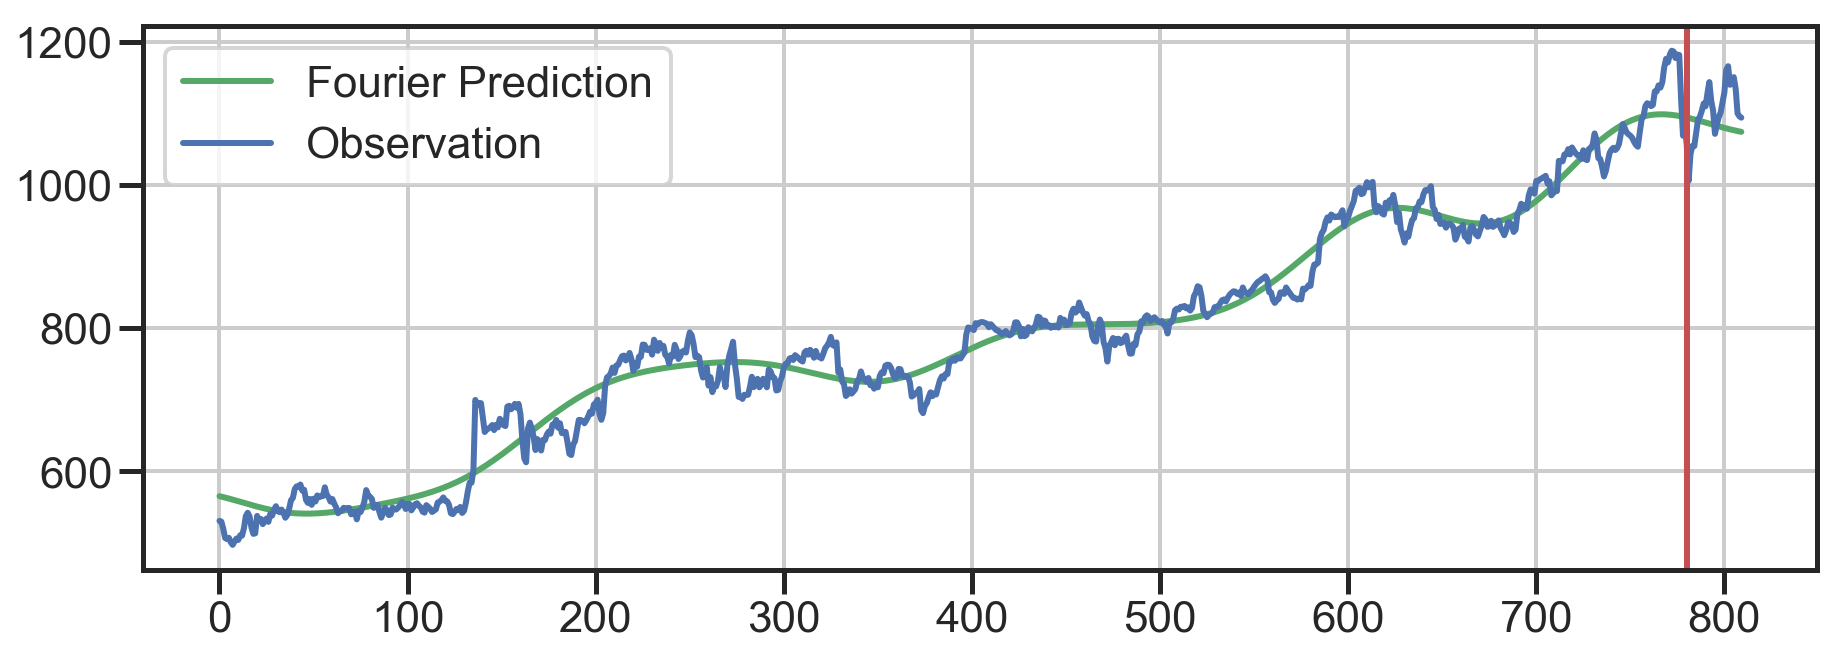

In [225]:
plotting_ts_entire_period(data, extrapolation,n_pred)

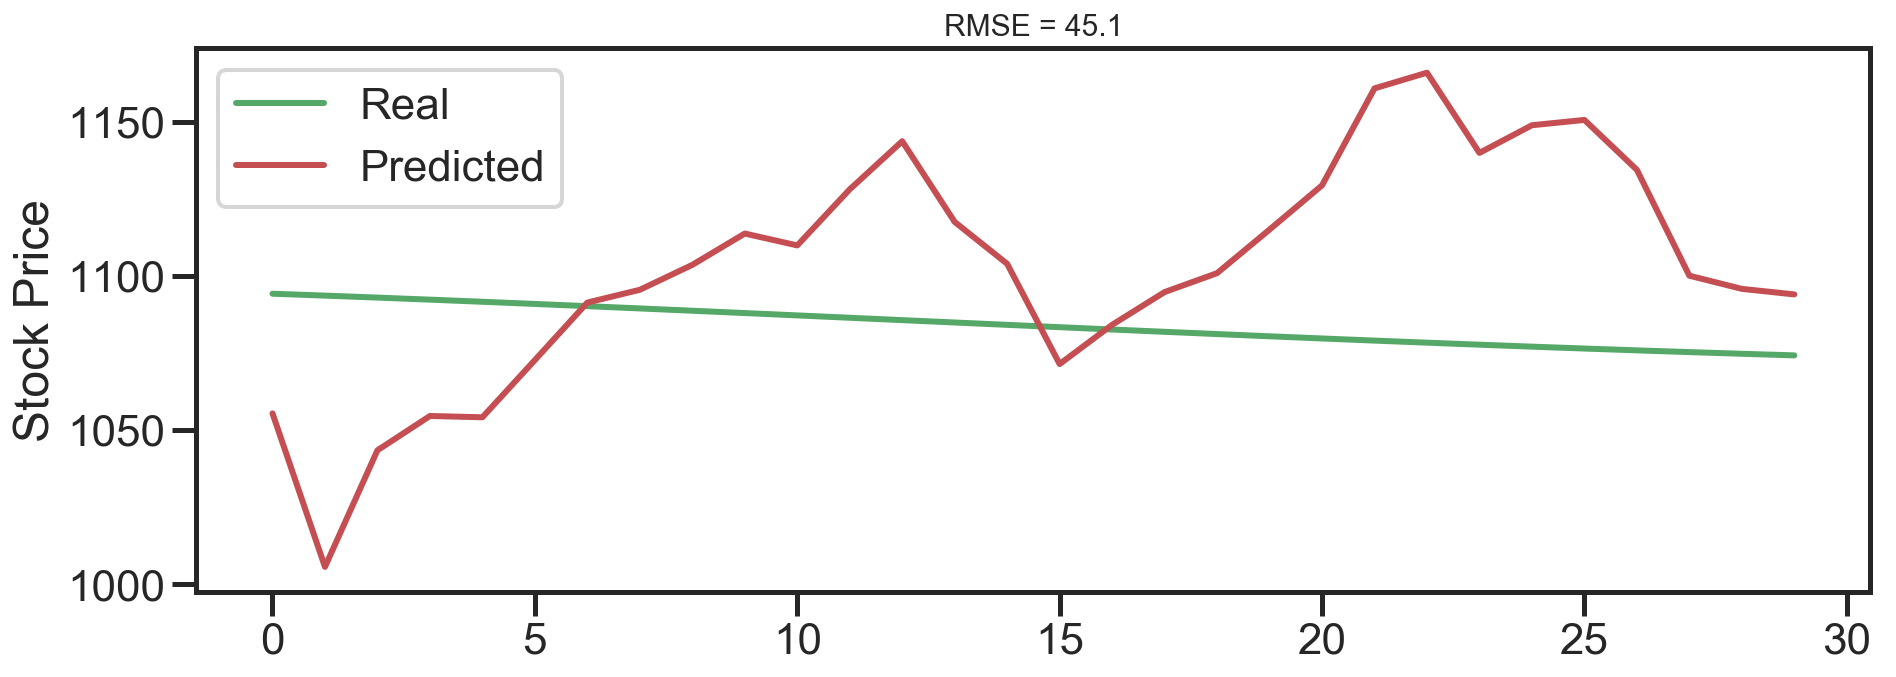

In [226]:
plot_prediction_real(extrapolation,y,n_pred)

## Difference

In [227]:
data = get_stock_price('GOOGL')

In [228]:
## start to train model 
train = data[:-n_pred]
test = data[-n_pred:]

In [229]:
pred_diff_fourier,pred_orignal = fourier_diff(train,n_pred)

dependent stationary for trainning: True


In [230]:
## dickfuller test to see if the residual is white noise 
residual = pred_orignal[-n_pred:]-y
dftest_y = sm.tsa.adfuller(residual,autolag='BIC')
dfoutput_y = pd.Series(dftest_y[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
WN = dfoutput_y[1]>0.05
print('White noise for residual : %s'%(WN))  
## The residual is not white noise
## We need to switch to Extrapolation fourier or try more time series model. 

White noise for residual : False


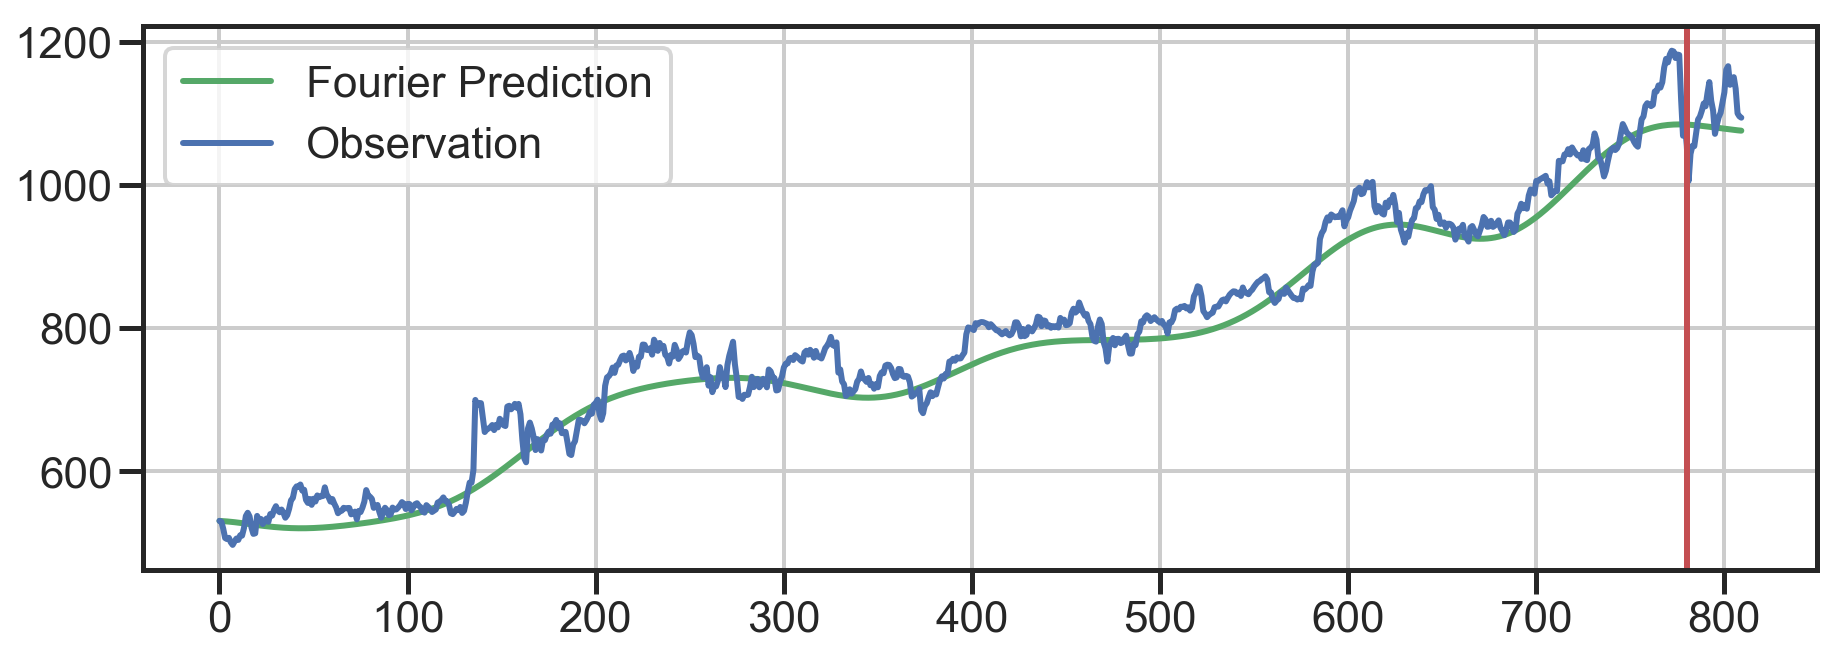

In [231]:
plotting_ts_entire_period(data,pred_diff_fourier,n_pred)

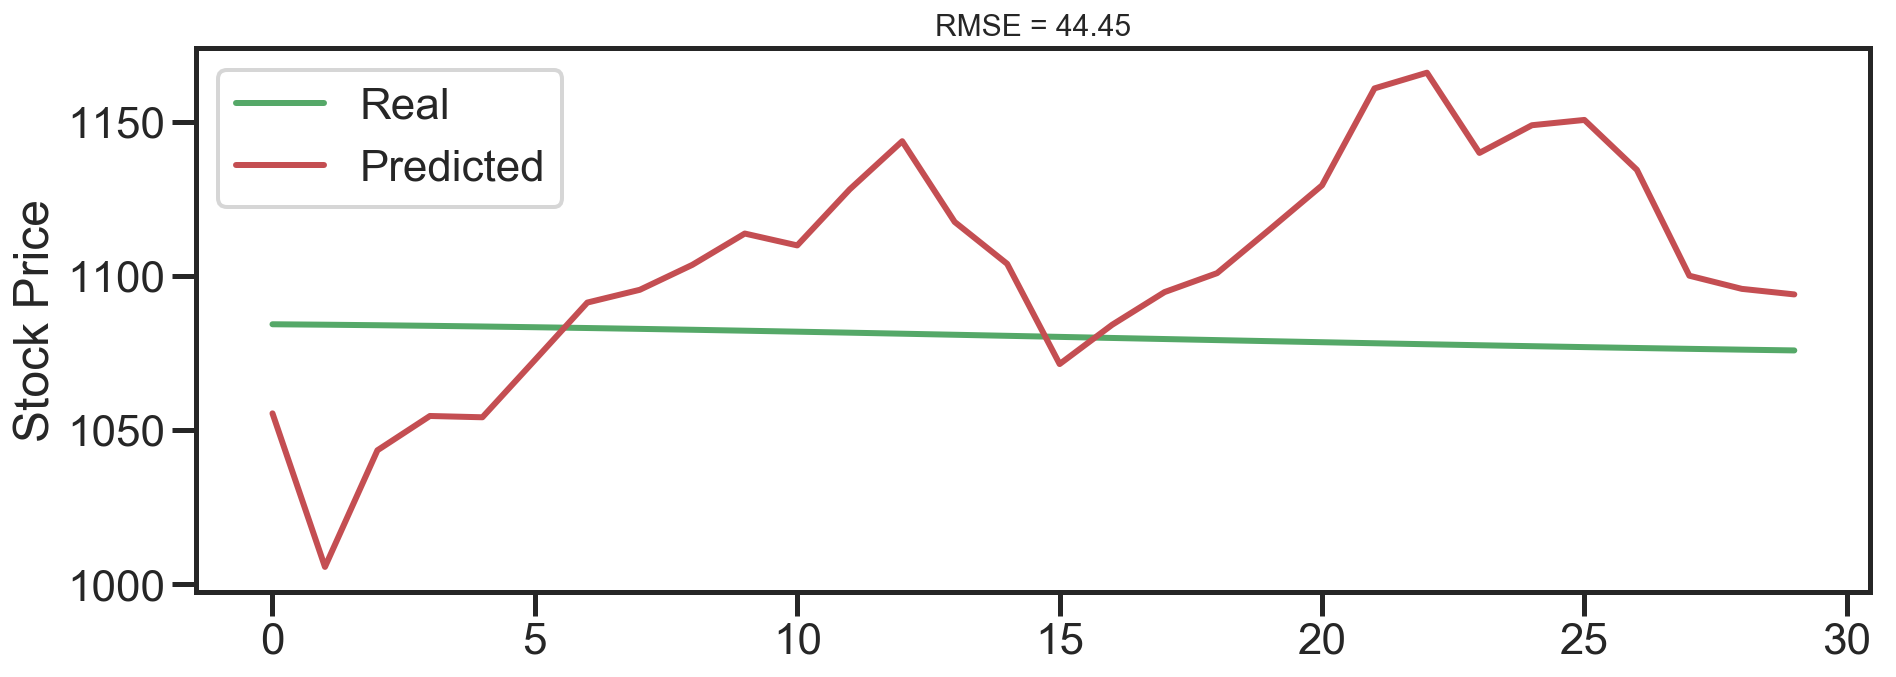

In [232]:
plot_prediction_real(pred_diff_fourier,test,n_pred)

## Summary 

In [233]:
## We should chose Extrapolation for fourier.

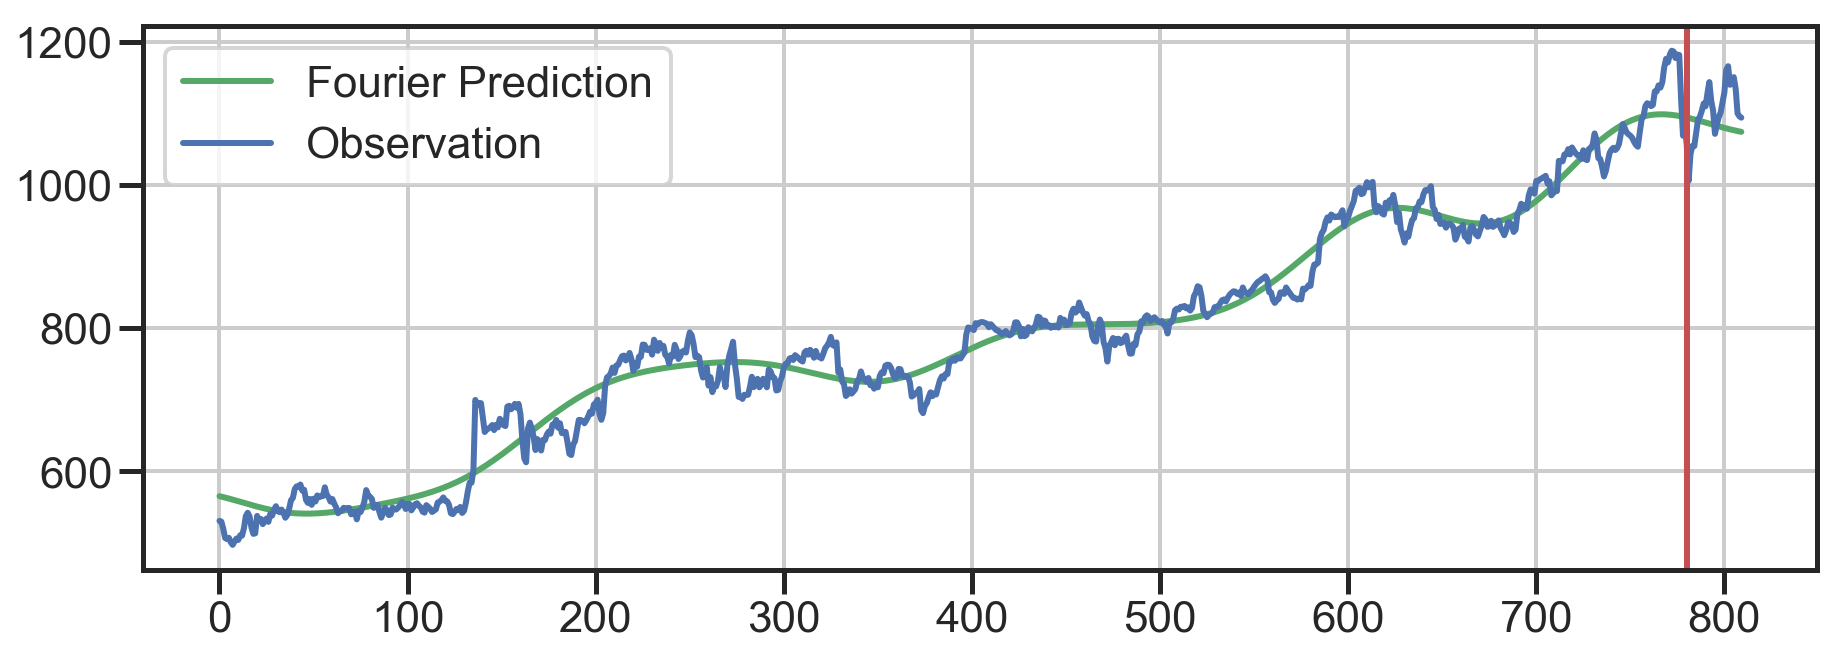

In [234]:
# Even The difference model's residual is not white noise, 
# we should look at extrapolation model's performance 

# this is the result for utilzing fourier to pred after detrend 
plotting_ts_entire_period(data, extrapolation,n_pred)

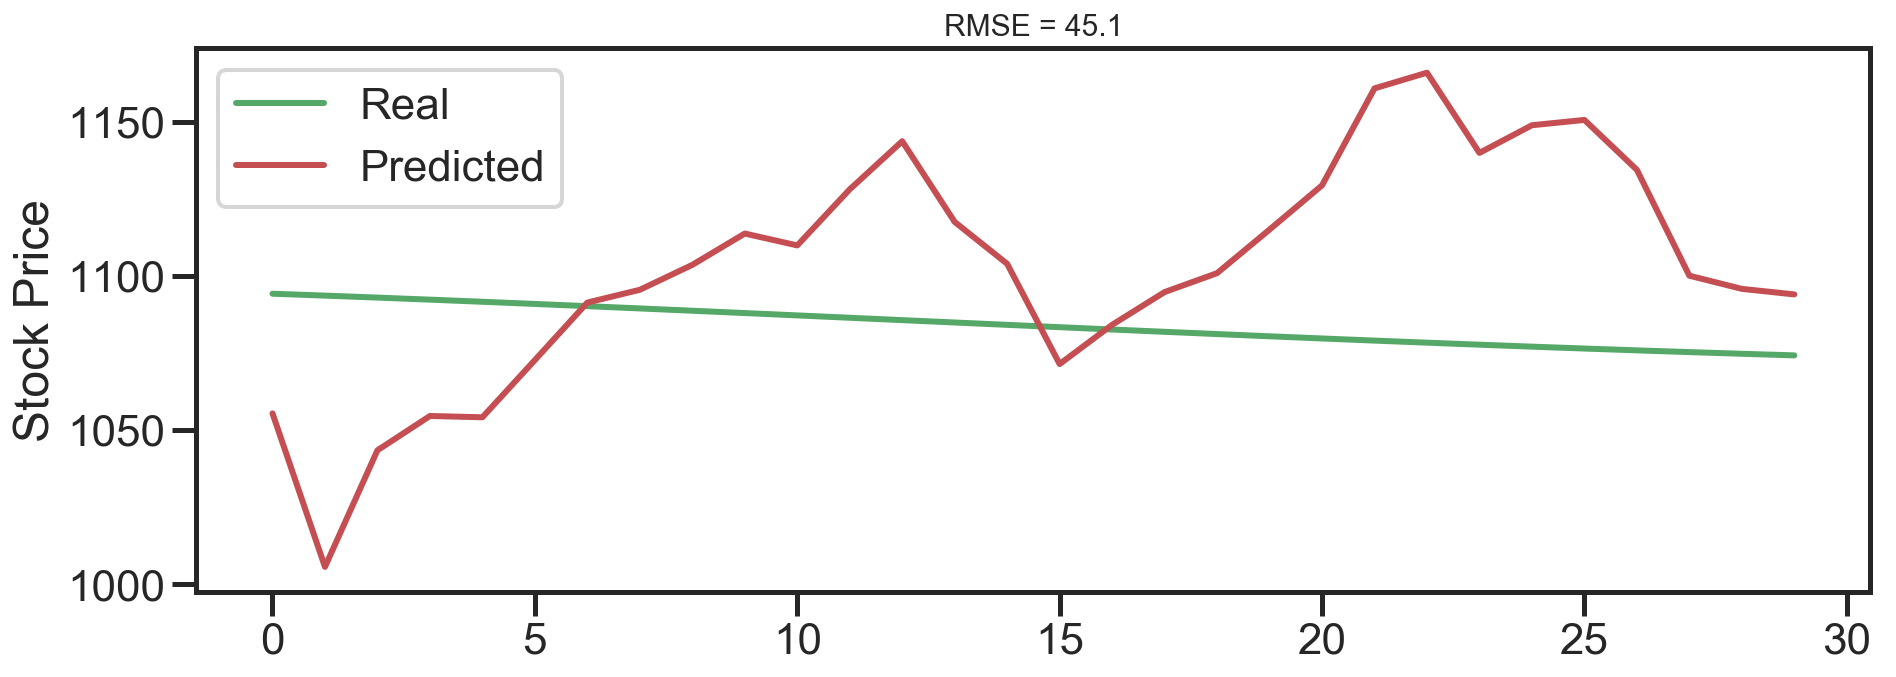

In [235]:
## only show the prediction period 
plot_prediction_real(extrapolation,y,n_pred)

In [236]:
## For RNN, RMSE is 45.3
## For Fourier, RMSE is 45.1
## Fourier win ! --from rmse perspective 
## However, time series analysis is utilizing the trend. 
## Based on the graph from Fourier, I can't much insight for the trend than RNN. 
## I still like RNN. 